# Mamba: Sequence Modeling with Selective State Spaces

Mamba was introduced in the paper:  “Mamba: Linear Time Sequence Modeling with Selective State Spaces” by Albert Gu and Tri Dao. 

Mamba is an expansion of State-Space Models (S4) which historically have been used for sequence modeling. Mamba is a linear time sequence model that uses a selective state space to reduce the computational complexity of the model. Unlike transformers, Mamba has a linear time complexity and can be trained on long sequences.

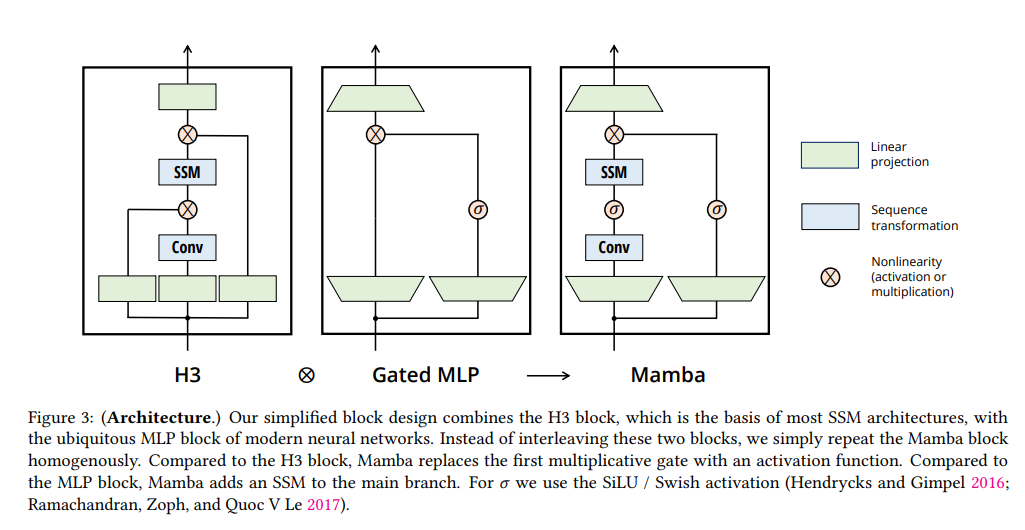

# References:

- [Mamba: Linear Time Sequence Modeling with Selective State Spaces](https://arxiv.org/abs/2312.00752)
- [Decoding Mamba: The Next Big Leap in AI Sequence Modeling](https://medium.com/ai-insights-cobet/decoding-mamba-the-next-big-leap-in-ai-sequence-modeling-ef3908060cb8)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from einops import rearrange

In [2]:
class RMSNorm(nn.Module):
    def __init__(self, normalized_shape: int, eps: float = 1e-6, device: str ='cuda'):
        super().__init__()
        self.eps = eps
        self.gain = nn.Parameter(torch.ones(normalized_shape, device=device))

    def forward(self, x: torch.Tensor):
        rms = torch.rsqrt((torch.mean(x.pow(2), dim=-1, keepdim=True) + self.eps))
        return x * rms * self.gain

In [3]:
class S6(nn.Module):
    def __init__(self, batch_size, seq_len, d_model, state_size, device):
        super(S6, self).__init__()

        self.fc1 = nn.Linear(d_model, d_model, device=device)
        self.fc2 = nn.Linear(d_model, state_size, device=device)
        self.fc3 = nn.Linear(d_model, state_size, device=device)

        self.seq_len = seq_len
        self.d_model = d_model
        self.state_size = state_size

        self.A = nn.Parameter(F.normalize(torch.ones(d_model, state_size, device=device), p=2, dim=-1))
        nn.init.xavier_uniform_(self.A)

        self.B = torch.zeros(batch_size, self.seq_len, self.state_size, device=device)
        self.C = torch.zeros(batch_size, self.seq_len, self.state_size, device=device)

        self.delta = torch.zeros(batch_size, self.seq_len, self.d_model, device=device)
        self.dA = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)
        self.dB = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)

        # h should have dimensions [batch_size, seq_len, d_model, state_size]
        self.h = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)
        self.y = torch.zeros(batch_size, self.seq_len, self.d_model, device=device)


    def discretization(self):
        # discretization function is defined based on the MAMBA paper's description using ZOH on page 28
        # in Section C : Mechanics on Selective SSMs
        # See also "Zero-order hold discretization" maths proof inside https://studywolf.wordpress.com/tag/zero-order-hold/
        """
        Here is an explanation of the mathematical rationale for the formulation of Δt used in Mamba:
        The key idea is that Δt controls the discretization rate of the continuous SSM dynamics. By making Δt input-dependent, it introduces selectivity into the discrete transition matrices.
        Specifically, in Mamba they parameterize Δt as:
        Δt = τΔ(Parameter + sΔ(xt))
        Where:
        - Parameter is a learned scalar parameter that controls the baseline discretization rate
        - sΔ(xt) is a projection that makes Δt input-dependent by computing a value based on xt
        - τΔ(x) = softplus(x) transforms the result to be positive through the softplus nonlinearity
        The rationale for this formulation is:
        - Parameter provides a reasonable default discretization rate
        - sΔ(xt) injects input-dependence through the projection
        - softplus ensures Δt is positive as required to be a valid timestep
        - The projection sΔ allows the model to learn to modulate Δt based on the input xt
        - This modulation creates selectivity in how rapidly or slowly the states update
        So in summary, the learned input-dependent projection allows Δt, and thus the discrete dynamics, to become selective. The softplus and scalar parameter provide useful inductive biases on top of this flexibility.
        The end result is discrete transition matrices that are selective on the input, enabling powerful sequence modeling capabilities.
        Credit: Claude2 AI chatbot
        """

        # inverse() only supports square matrix
        #dB = torch.matmul(torch.inverse(A * delta), torch.matmul(dA - torch.eye(A.shape[0]), B))
        self.dB = torch.einsum("bld,bln->bldn", self.delta, self.B)

        # https://github.com/state-spaces/mamba/blob/0131c1e94a46fc9f70bcfc9d57962963bb2f0b9e/mamba_ssm/modules/mamba_simple.py#L240
        #dA = torch.matrix_exp(A * delta)  # matrix_exp() only supports square matrix
        self.dA = torch.exp(torch.einsum("bld,dn->bldn", self.delta, self.A))
        #print(f"self.dA.shape = {self.dA.shape}")
        #print(f"self.dA.requires_grad = {self.dA.requires_grad}")

        return self.dA, self.dB

    def forward(self, x):
        # Refer to Algorithm 2 in the MAMBA paper
        self.B = self.fc2(x)
        self.C = self.fc3(x)
        self.delta = F.softplus(self.fc1(x))

        # Uses ZOH as in MAMBA, Hungry Hippo still uses bilinear transform for discretization
        self.discretization()

        if DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM:  # this will trigger in-place runtime error if without using `h_new`
          
            global current_batch_size
            current_batch_size = x.shape[0]

            if self.h.shape[0] != current_batch_size:
                #print("Adjusting h_new for the different batch size of input data `x`")
                different_batch_size = True

                # Resize self.h to match the current batch size
                h_new =  torch.einsum('bldn,bldn->bldn', self.dA, self.h[:current_batch_size, ...]) + rearrange(x, "b l d -> b l d 1") * self.dB

            else:
                different_batch_size = False
                h_new =  torch.einsum('bldn,bldn->bldn', self.dA, self.h) + rearrange(x, "b l d -> b l d 1") * self.dB

            # y needs to have a shape of [batch_size, seq_len, d_model]
            self.y = torch.einsum('bln,bldn->bld', self.C, h_new)

            # Update self.h with the detached state of h_new
            # Only do this if retaining gradients for self.h is not necessary for backprop
            # Otherwise, store h_new in a temporary list and update self.h after the loop
            global temp_buffer
            temp_buffer = h_new.detach().clone() if not self.h.requires_grad else h_new.clone()
  
            return self.y

        else:  # this will not trigger in-place runtime error
            # h should have dimensions [batch_size, seq_len, d_model, state_size]
            h = torch.zeros(x.size(0), self.seq_len, self.d_model, self.state_size, device=x.device)
            y = torch.zeros_like(x)

            h =  torch.einsum('bldn,bldn->bldn', self.dA, h) + rearrange(x, "b l d -> b l d 1") * self.dB

            # y needs to have a shape of [batch_size, seq_len, d_model]
            y = torch.einsum('bln,bldn->bld', self.C, h)

            return y

In [4]:
class MambaBlock(nn.Module):
    def __init__(self, batch_size, sequence_length, model_dim, state_size, device):
        super().__init__()

        self.input_projection = nn.Linear(model_dim, 2 * model_dim, device=device)
        self.output_projection = nn.Linear(2 * model_dim, model_dim, device=device)

        # For residual skip connection
        self.residual_projection = nn.Linear(model_dim, 2 * model_dim, device=device)

        # Set _no_weight_decay attribute on bias and initialize bias to a small constant value
        self.output_projection.bias._no_weight_decay = True
        nn.init.constant_(self.output_projection.bias, 1.0)

        self.ssm_layer = S6(batch_size, sequence_length, 2 * model_dim, state_size, device)

        # Add 1D convolution with kernel size 3
        self.convolution = nn.Conv1d(sequence_length, sequence_length, kernel_size=3, padding=1, device=device)

        # Add linear layer for convolution output
        self.conv_output_projection = nn.Linear(2 * model_dim, 2 * model_dim, device=device)

        # RMSNorm layer
        self.normalization = RMSNorm(model_dim, device=device)

    def forward(self, x):
        """
        Forward pass for MambaBlock
        """
        x_normalized = self.normalization(x)

        projected_input = self.input_projection(x_normalized)

        # 1D convolution with kernel size 3
        conv_output = self.convolution(projected_input)

        activated_conv_output = F.silu(conv_output)

        # Linear layer for convolution output
        projected_conv_output = self.conv_output_projection(activated_conv_output)

        ssm_output = self.ssm_layer(projected_conv_output)
        activated_ssm_output = F.silu(ssm_output)  # Swish activation can be implemented as x * sigmoid(x)

        # Residual skip connection with nonlinearity introduced by multiplication
        residual = F.silu(self.residual_projection(x_normalized))
        combined_output = activated_ssm_output * residual

        final_output = self.output_projection(combined_output)

        return final_output

In [5]:
class Mamba(nn.Module):
    def __init__(self, batch_size, seq_len, d_model, state_size, device):
        super(Mamba, self).__init__()
        self.mamba_block1 = MambaBlock(batch_size, seq_len, d_model, state_size, device)
        self.mamba_block2 = MambaBlock(batch_size, seq_len, d_model, state_size, device)
        self.mamba_block3 = MambaBlock(batch_size, seq_len, d_model, state_size, device)
        self.norm = RMSNorm(d_model, device=device)

    def forward(self, x):
        x = self.mamba_block1(x)
        x = self.mamba_block2(x)
        x = self.mamba_block3(x)
        return x

In [6]:
DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM = 0

In [7]:
# User-defined hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model = 8
state_size = 128  # Example state size
seq_len = 100  # Example sequence length
batch_size = 256  # Example batch size
last_batch_size = 81  # only for the very last batch of the dataset
current_batch_size = batch_size
different_batch_size = False
h_new = None
temp_buffer = None

In [8]:
x = torch.rand(batch_size, seq_len, d_model, device=device)
# Create the Mamba model
mamba = Mamba(batch_size, seq_len, d_model, state_size, device)

# Forward pass
test_output = mamba(x)
print(f"test_output.shape = {test_output.shape}")  # Should be [batch_size, seq_len, d_model]

test_output.shape = torch.Size([256, 100, 8])
